<a href="https://colab.research.google.com/github/Jasonhcwong/face-recognition-system/blob/main/detect_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone the repo and install required library

In [1]:
!git clone https://github.com/Jasonhcwong/face-recognition-system.git
%cd face-recognition-system

!pip install mtcnn

fatal: destination path 'face-recognition-system' already exists and is not an empty directory.
/content/face-recognition-system
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import required library

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import face_preprocess

from mtcnn import MTCNN

# Helper functions

In [3]:
def euclidian_distance(embeddings1, embeddings2):
    embeddings1 = embeddings1/np.linalg.norm(embeddings1, axis=0, keepdims=True)
    embeddings2 = embeddings2/np.linalg.norm(embeddings2, axis=0, keepdims=True)
    dist = np.sqrt(np.sum(np.square(np.subtract(embeddings1, embeddings2))))
    return dist

def calc_confidence(distance, threshold=1.2333):
    return 0 if distance >= threshold else (1.0-distance/threshold)

def compare_faces(embeddings1, embeddings2):
    dist = euclidian_distance(embeddings1, embeddings2)
    conf = calc_confidence(dist)
    return dist, conf

def find_nearest_person(embedding, face_db, threshold):
    min_distance = 999
    person = "Unknown"
    for embd, name in face_db:
        distance, confidence = compare_faces(embd, embedding)
        if distance < threshold and distance < min_distance:
            min_distance = distance
            person = name
    return (person, min_distance)

# Initialize MTCNN, load face embedding model and create known-faces database

In [4]:
##### initialize mtcnn
detector = MTCNN()
mtcnn_min_conf = 0.9

##### initialize face recognition model (saved_model)
ckpt_dir = './ckpt/epoch_13'
train_model = tf.keras.models.load_model(ckpt_dir)
model = tf.keras.Model(train_model.get_layer('input').input, train_model.get_layer('embedding').output, trainable=False)
#model.summary()

# load known faces from folder
known_faces_mtcnn_dir = './known_faces_mtcnn/'
known_face_db = []
for root, subdirectories, _ in os.walk(known_faces_mtcnn_dir):
    for person in subdirectories:
        print('processing person: ' + person)
        for subroot, _, files in os.walk(os.path.join(root, person)):
            for file in files:
                full_path =  os.path.join(subroot, file)
                print('processing file: ' + full_path)
                img = cv2.imread(full_path)
                img = cv2.resize(img, (112, 112))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img - 127.5
                img = img * 0.0078125
                img_tensor = np.expand_dims(img, axis=0)
                #print(img_tensor.shape)
                result = model.predict(img_tensor, batch_size=1, verbose=0)
                known_face_db.append((result.flatten(), person))
                #known_face_db.append((result, person))

#print(known_face_db)

processing person: Charlie_Brooker
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_4.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_11.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_13.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_10.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_7.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_2.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_12.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_3.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_8.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_14.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_6.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie_Brooker_1.jpg
processing file: ./known_faces_mtcnn/Charlie_Brooker/Charlie

# Helper functions for webcam capturing

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Webcam capture and face recognition

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 39ms/step


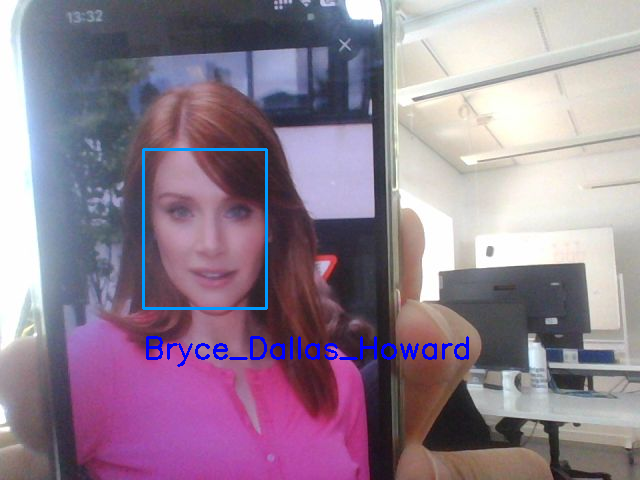

In [7]:
from PIL import Image
try:
  filename = take_photo()

  img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
  img_with_dets = img.copy()

  detections = detector.detect_faces(img)
  for det in detections:
                if det['confidence'] >= mtcnn_min_conf:
                    x, y, width, height = det['box']
                    keypoints = det['keypoints']
                    cv2.rectangle(img_with_dets, (x,y), (x+width,y+height), (0,155,255), 2)
                       
                    bbox = det["box"]
                    bbox = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])
                    landmarks = det["keypoints"]

                    # convert to face_preprocess.preprocess input
                    landmarks = np.array([landmarks["left_eye"][0], landmarks["right_eye"][0], landmarks["nose"][0],landmarks["mouth_left"][0], landmarks["mouth_right"][0],landmarks["left_eye"][1], landmarks["right_eye"][1], landmarks["nose"][1], landmarks["mouth_left"][1], landmarks["mouth_right"][1]])
                    landmarks = landmarks.reshape((2,5)).T
                    nimg = face_preprocess.preprocess(img, bbox, landmarks, image_size='112,112')
                    
                    # calculate face embedding
                    nimg = nimg - 127.5
                    nimg = nimg * 0.0078125
                    nimg_tensor = np.expand_dims(nimg, axis=0)
                    result = model.predict(nimg_tensor, batch_size=1, verbose=0)
                    embedding = result.flatten()
            
                    # find nearest face in db
                    dist_threshold = 1.1
                    name, dist = find_nearest_person(embedding, known_face_db, dist_threshold)
                    # Show detected person
                    if dist < dist_threshold:
                        img_with_dets = cv2.putText(img_with_dets, name, (x, y+height+50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
                        #img_with_dets = cv2.putText(img_with_dets, str(dist), (x, y+height+100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
                    else:
                        img_with_dets = cv2.putText(img_with_dets, 'Unknown person', (x, y+height+50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
  
  # Show the image with detection result.
  display(Image.fromarray(img_with_dets))
except Exception as err:
  print(str(err))